<a href="https://colab.research.google.com/github/Ninja-State/NMA-DL-Project/blob/Miguel/NMA_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Importing Libraries

import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#@title CUDA Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#@title Plotting params

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Loading Spiking times
fname1 = ['steinmetz_st.npz']
fname1.append('steinmetz_wav.npz')
fname1.append('steinmetz_lfp.npz')
url2 = ["https://osf.io/4bjns/download"]
url2.append("https://osf.io/ugm9v/download")
url2.append("https://osf.io/kx3v9/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
dat2 = dat_ST[11]
del dat_ST
print(dat2.keys())

dict_keys(['ss', 'ss_passive'])


In [5]:
#@title Load Binned Times

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [6]:
#@title DF form
dt_waveforms = 1/30000 # dt of waveform
binsize = dat['bin_size'] # bin times spikes
mean_firing = dat['spks'].mean(axis = (1,2)) * 1/binsize # computing mean firing rate
t_t_peak = dat['trough_to_peak'] * dt_waveforms * 1e3 # computing trough to peak time in ms


labeling_df = pd.DataFrame({
    "Mean Firing Rate": mean_firing,
    "Trough to peak": t_t_peak,
    "Region": dat['brain_area'],
    "Area":dat['brain_area']
})
labeling_df.replace(
    {
        "Area": {"CA1":"Hippocampus","DG":"Hippocampus","SUB":"Hippocampus",
        "VISp": "Visual Ctx", "VISam":"Visual Ctx","MD":"Thalamus","LGd":"Thalamus", "LH":"Thalamus",
        "PL":"Other Ctx","MOs":"Other Ctx","ACA":"Other Ctx"
        }
    }, inplace = True
)

# Labeling according to conditions, other is the default condition
labeling_df['Cell Type'] = "Other"
labeling_df.loc[(labeling_df['Mean Firing Rate']<5)&(labeling_df['Trough to peak']>0.4),'Cell Type'] = "Excitatory"
labeling_df.loc[(labeling_df['Mean Firing Rate']>5)&(labeling_df['Trough to peak']<0.4), 'Cell Type'] = "Inhibitory"

labeling_df.head(20)

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type
0,0.731765,0.800000,VISp,Visual Ctx,Excitatory
1,0.237647,0.666667,VISp,Visual Ctx,Excitatory
2,5.368235,0.766667,VISp,Visual Ctx,Other
3,0.190588,0.566667,DG,Hippocampus,Excitatory
4,1.356471,0.633333,VISp,Visual Ctx,Excitatory
5,0.000000,0.733333,VISp,Visual Ctx,Excitatory
6,0.141176,0.600000,SUB,Hippocampus,Excitatory
7,2.327059,0.733333,DG,Hippocampus,Excitatory
8,0.030588,0.633333,VISp,Visual Ctx,Excitatory
9,0.798824,0.400000,VISp,Visual Ctx,Other


In [7]:
labeling_df['Region'].unique()

array(['VISp', 'DG', 'SUB', 'LGd', 'PL', 'root', 'MOs', 'ACA', 'CA1',
       'VISam', 'MD', 'LH'], dtype=object)

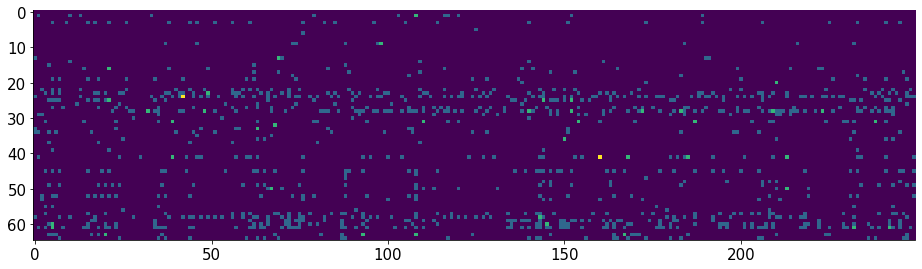

In [8]:
#dat['spks'][1,:,].shape
#Neurons,trials,time
plt.imshow(dat['spks'][dat['brain_area']=='DG',3,:])


In [9]:
#@title Raster visualizer
from ipywidgets import interact
import ipywidgets as widgets
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
def raster_visualizer(area,trial):
  spikes= dat2['ss']
  plt.figure(figsize=(9,5))
  plt.eventplot(spikes[labeling_df['Area']==area][:,trial],color='k')
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Excitatory')][:,trial]);
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Other')][:,trial],color='k');
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Inhibitory')][:,trial],colors = 'r');
  #plt.yticks([]);
  plt.vlines(0.5,0,len(spikes[(labeling_df['Area']==area)])-10,'red','--',alpha=0.5)
  plt.ylabel('Neurons');
  plt.xlabel('Time ($s$)');
  plt.title(f'Trial was correct?:{is_correct[trial]}')
interact(raster_visualizer, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx'], trial=(0,339));

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

In [10]:
#@title Mean firing rate based on response
# response = dat['response'] # right - nogo - left (-1, 0, 1)

def mean_firing(area):
  Selection = (labeling_df['Area']==area) #& (labeling_df['Cell Type']=='Excitatory')
  spikes = dat['spks'][Selection].mean(axis = 0) #selecting spikes
  mean_fr_e = spikes[is_correct==True].mean(axis=(0))*1/binsize
  mean_fr_i = spikes[is_correct==False].mean(axis=(0))*1/binsize
  time = binsize * np.arange(dat['spks'].shape[-1])
  plt.plot(time, mean_fr_e,label='correct')
  plt.plot(time, mean_fr_i,label='incorrect')
  plt.axvline(x=0.5,ls = '--', alpha = 0.5, c = 'r', label='Stim')
  plt.axvline(x=np.mean(dat['response_time']),ls = '--', alpha = 0.5, c = 'k', label='Response')
  plt.ylabel('Mean Firing Rate ($Hz$)')
  plt.xlabel('Time ($ms$)')
  plt.legend()
interact(mean_firing, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx']);

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

In [11]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z= F.softplus(self.fc(q), 10)

    return z, q



In [12]:
def trainmodel(model,x_1,x_0,niter=1000):
# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
  optimizer = torch.optim.Adam(model.parameters(), lr=.005)
  def Poisson_loss(lam, spk):
    return lam - spk * torch.log(lam)

  for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
    pred, latent = model(x_1)
  # our log-likelihood cost
    cost = Poisson_loss(pred, x_0).mean()
  # train the network as usual
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

    if k % 100 == 0:
      print(f'iteration {k}, cost {cost.item():.4f}')

In [13]:
def evaluatemodel(x_0,model):
  pred, latent = net(x_0)
  return pred, latent

In [14]:
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

# Data to feed

Here we specify with which subset of data the RNN will be feed it.

In [15]:
Data_to_feed = dat['spks'][labeling_df['Area']=='Visual Ctx',:,:].T
Data_to_feed.shape

(250, 340, 145)

In [16]:
div_neurons = int(Data_to_feed.shape[-1]/2)
x=Data_to_feed
idx=np.random.choice(x.shape[-1],x.shape[-1])

Separating inputs and outputs:

In [17]:
if x.shape[-1] % 2 == 0:
  x0 = torch.from_numpy(x[:, :, idx[:div_neurons]]).to(device).float()
  x1 = torch.from_numpy(x[:, :,idx[div_neurons:]]).to(device).float()
else:
  x0 = torch.from_numpy(x[:, :, idx[:div_neurons+1]]).to(device).float()
  x1 = torch.from_numpy(x[:, :,idx[div_neurons:]]).to(device).float()

print(f"Input shape: {x1.shape}")
print(f"Output shape. {x0.shape}")

Input shape: torch.Size([250, 340, 73])
Output shape. torch.Size([250, 340, 73])


In [18]:
NN1 = x1.shape[-1]
NN2 = x0.shape[-1]
ncomp = 6

#Define the model
net = Net(ncomp, NN1, NN2, bidi = True).to(device)
# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean((1,2)).mean()

In [19]:
trainmodel(net,x1,x0,1000)

iteration 0, cost 0.1611
iteration 100, cost 0.0751
iteration 200, cost 0.0717
iteration 300, cost 0.0708
iteration 400, cost 0.0701
iteration 500, cost 0.0698
iteration 600, cost 0.0695
iteration 700, cost 0.0694
iteration 800, cost 0.0692
iteration 900, cost 0.0691


In [20]:
pred, latent = evaluatemodel(x0,net)

In [21]:
y = x0.detach().cpu().numpy()

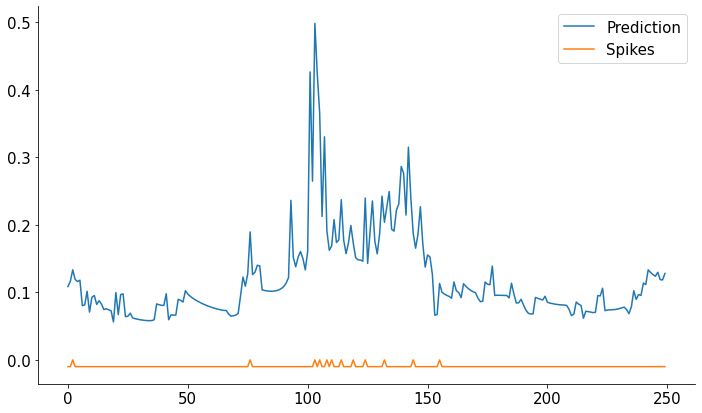

In [22]:
rpred = pred.detach().cpu().numpy()

plt.figure(figsize=(10, 6))

trial = 0
neuron = 0
plt.plot(rpred[:,trial,neuron], label='Prediction')
plt.plot(y[:,trial,neuron]*.01 -.01, label= 'Spikes')
plt.legend()
plt.show()

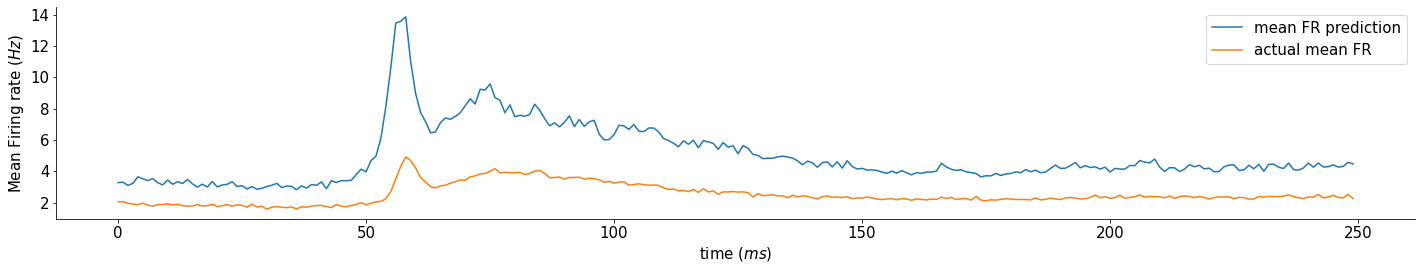

In [23]:
plt.plot(rpred.mean((1,2))*1/binsize, label='mean FR prediction')
plt.plot(Data_to_feed.mean((1,2))*1/binsize, label = 'actual mean FR')
plt.ylabel('Mean Firing rate ($Hz$)')
plt.xlabel('time ($ms$)')
plt.legend()

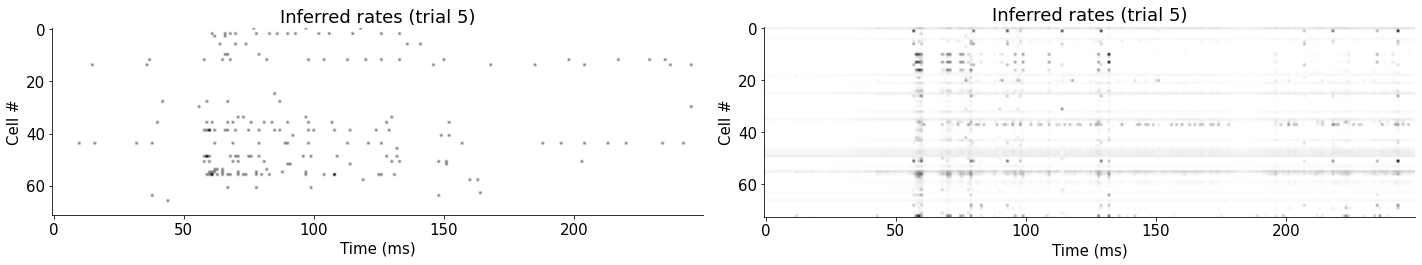

In [24]:
plt.figure(figsize = (20, 10))
trial = 5
plt.subplot(121)
plt.imshow(x[:, trial, :div_neurons].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates (trial {trial})')

plt.subplot(122)
plt.imshow(rpred[:, trial, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates (trial {trial})')
plt.show()

#40 good trial

In [25]:
latent = latent.detach().cpu().numpy()

In [26]:
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)

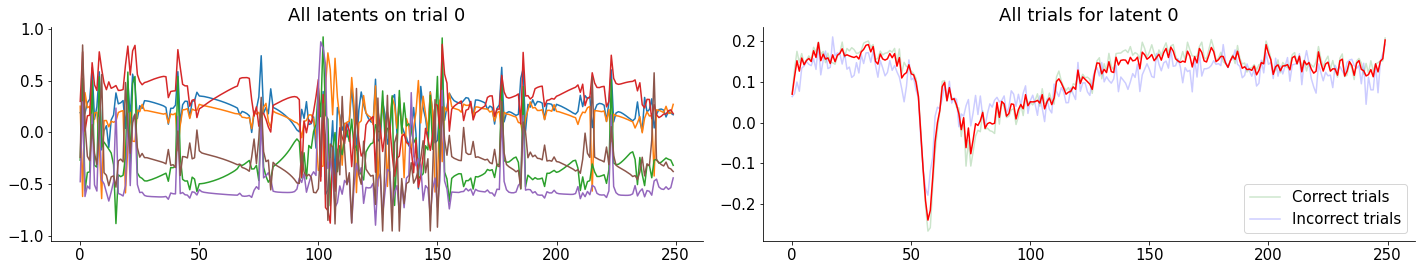

In [27]:
plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(latent[:, 0, :]);
plt.title('All latents on trial 0')

latent_idx = 0
plt.subplot(122)
plt.plot(latent[:, is_correct==True, latent_idx].mean(1),color ='green',alpha=0.2, label='Correct trials')
plt.plot(latent[:, is_correct==False, latent_idx].mean(1),color ='blue',alpha=0.2, label='Incorrect trials')
plt.plot(latent[:, :, latent_idx].mean(axis=1),color ='red')
plt.legend()
plt.title(f'All trials for latent {latent_idx}')
plt.show()

#Training and testing over trials

In [28]:
Data_to_feed = dat['spks'][labeling_df['Area']=='Visual Ctx',:,:].T
Data_to_feed.shape

(250, 340, 145)

In [29]:
div_trials = 0.8
x=Data_to_feed
idx=np.random.choice(x.shape[1],x.shape[1])
cut=int(len(idx)*0.8)

In [30]:
train_data = torch.from_numpy(x[:,idx[:cut],:]).to(device).float()
test_data = torch.from_numpy(x[:,idx[cut:],:]).to(device).float()
print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: torch.Size([250, 272, 145])
Test shape: torch.Size([250, 68, 145])


In [31]:
NN = train_data.shape[-1]
ncomp = 6
net = Net(ncomp, NN, NN, bidi = True).to(device)
net.fc.bias.data[:] = train_data.mean((1,2)).mean()
trainmodel(net,train_data,train_data,1000)

iteration 0, cost 0.1932
iteration 100, cost 0.0759
iteration 200, cost 0.0723
iteration 300, cost 0.0709
iteration 400, cost 0.0699
iteration 500, cost 0.0691
iteration 600, cost 0.0684
iteration 700, cost 0.0679
iteration 800, cost 0.0675
iteration 900, cost 0.0671


In [32]:
pred, latent = evaluatemodel(test_data,net)

In [33]:
y = test_data.detach().cpu().numpy()
rpred = pred.detach().cpu().numpy()
latent = latent.detach().cpu().numpy()

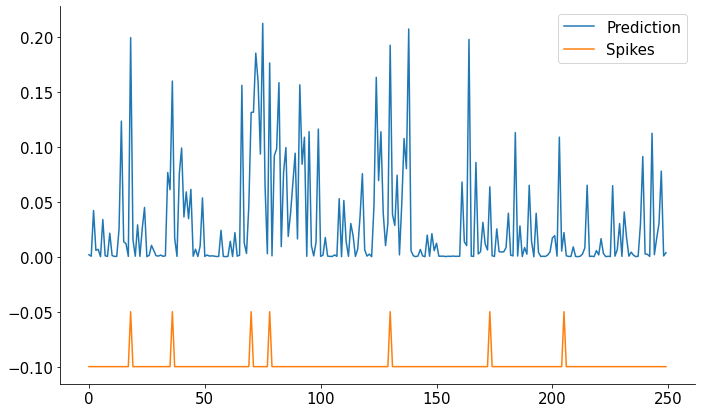

In [34]:
plt.figure(figsize=(10, 6))

trial = 0
neuron = 50
plt.plot(rpred[:,trial,neuron], label='Prediction')
plt.plot(y[:,trial,neuron]*.05 -.10, label= 'Spikes')
plt.legend()
plt.show()

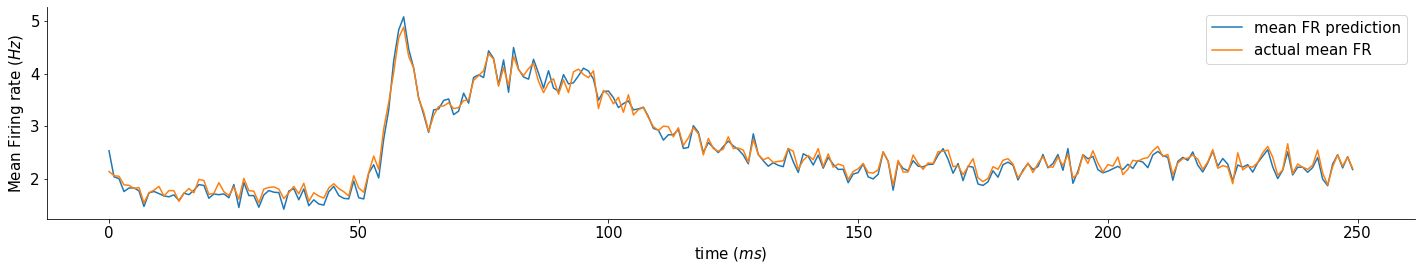

In [35]:
plt.plot(rpred.mean((1,2))*1/binsize, label='mean FR prediction')
plt.plot(y.mean((1,2))*1/binsize, label = 'actual mean FR')
plt.ylabel('Mean Firing rate ($Hz$)')
plt.xlabel('time ($ms$)')
plt.legend()

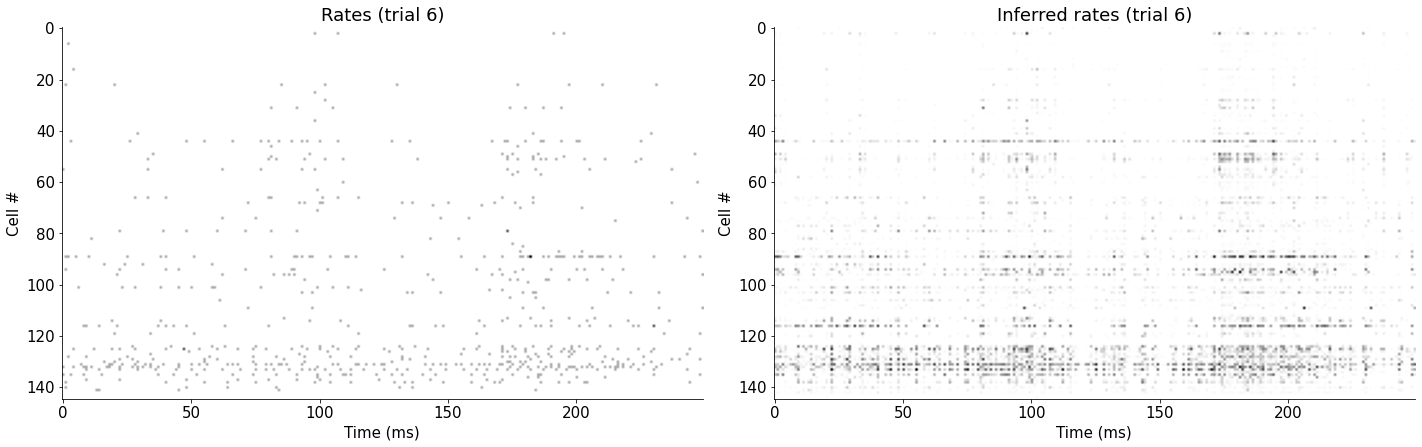

In [36]:
plt.figure(figsize = (20, 10))
trial = 6
plt.subplot(121)
plt.imshow(y[:, trial, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Rates (trial {trial})')

plt.subplot(122)
plt.imshow(rpred[:, trial, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates (trial {trial})')
plt.show()

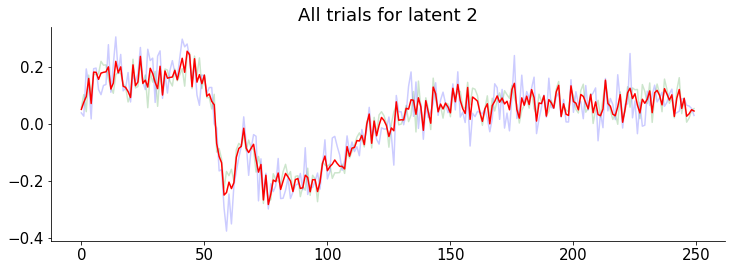

In [37]:
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)

latent_idx = 2
plt.subplot(122)
plt.plot(latent[:, is_correct[cut:]==True, latent_idx].mean(1),color ='green',alpha=0.2, label='Correct trials')
plt.plot(latent[:, is_correct[cut:]==False, latent_idx].mean(1),color ='blue',alpha=0.2, label='Incorrect trials')
plt.plot(latent[:, :, latent_idx].mean(axis=1),color ='red')
#plt.legend()
plt.title(f'All trials for latent {latent_idx}')
plt.show()

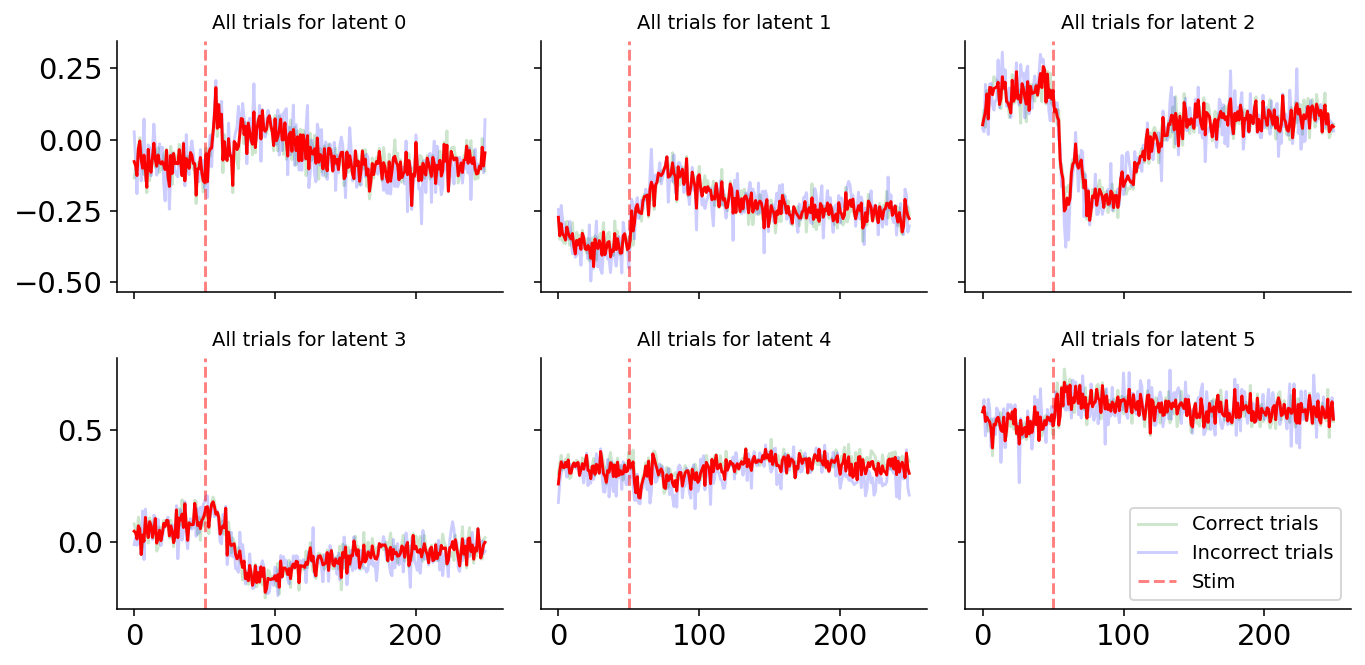

In [38]:
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize = (10,5), dpi = 140)
for latent_idx, item in enumerate(ax.reshape(-1)):
  item.plot(latent[:, is_correct[cut:]==True, latent_idx].mean(1),color ='green',alpha=0.2, label='Correct trials')
  item.plot(latent[:, is_correct[cut:]==False, latent_idx].mean(1),color ='blue',alpha=0.2, label='Incorrect trials')
  item.plot(latent[:, :, latent_idx].mean(axis=1),color ='red')
  item.set_title(f'All trials for latent {latent_idx}', fontsize=10)
  item.axvline(x=50,ls = '--', alpha = 0.5, c = 'r', label='Stim')
plt.legend(fontsize=10)
    

# RNN Classifier

In [39]:
class RNNClass(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,num_classes):
    super(RNNClass,self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size,hidden_size,num_layers)
    self.fc = nn.Linear(hidden_size,num_classes)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers,x.size(1),self.hidden_size).to(device)
    out,h = self.rnn(x,h0)

    out = out[-1,:,:]
    out = self.fc(out)
    return out, h


In [46]:
input = torch.from_numpy(dat['spks'][labeling_df['Area']=='Visual Ctx',:,:].T.astype(np.float32)).to(device)
labels = torch.from_numpy(is_correct.astype(np.int)).to(device)

In [50]:
input_size = input.shape[-1]
hidden_size = 6
num_layers = 1
num_classes = 2
learning_rate = 0.001
niter = 2000

In [51]:
model = RNNClass(input_size,hidden_size,num_layers,num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for k in range(niter):
  outputs, h = model(input)
  #print(outputs)
  loss = criterion(outputs,labels)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if k % 100 == 0:
    print(f'iteration {k}, cost {loss.item():.4f}')

iteration 0, cost 0.6316
iteration 100, cost 0.5253
iteration 200, cost 0.3612
iteration 300, cost 0.1807
iteration 400, cost 0.0699
iteration 500, cost 0.0301
iteration 600, cost 0.0159
iteration 700, cost 0.0099
iteration 800, cost 0.0106
iteration 900, cost 0.0070
iteration 1000, cost 0.0057
iteration 1100, cost 0.0048
iteration 1200, cost 0.0041
iteration 1300, cost 0.0035
iteration 1400, cost 0.0031
iteration 1500, cost 0.0027
iteration 1600, cost 0.0024
iteration 1700, cost 0.0022
iteration 1800, cost 0.0019
iteration 1900, cost 0.0017
